In [1]:
%cd ..
import pandas as pd
import numpy as np 
import glob
import matplotlib.pyplot as plt

import hdf5storage
import h5py
import scipy.io as sio

import sys,os
import seaborn as sns

import functions,loading

import nelpy as nel  # main nelpy imports
import nelpy.plotting as npl  # optional plotting import

import math
import itertools
from scipy import stats
import multiprocessing
from joblib import Parallel, delayed


d:\github\ripple_heterogeneity\python


C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\plotting\decoding.py:9: MatplotlibDeprecationWarning: 
The mpl_toolkits.axes_grid module was deprecated in Matplotlib 2.1 and will be removed two minor releases later. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist, which provide the same functionality instead.


In [2]:
tex_fonts = {
#     # Use LaTeX to write all text
#     "text.usetex": True,
    "font.family": "serif",
    # Use 10pt font in plots, to match 10pt font in document
    "axes.labelsize": 10,
    "font.size": 10,
    # Make the legend/label fonts a little smaller
    "legend.fontsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    "svg.fonttype": 'none'
}
plt.style.use('seaborn-paper')
# plt.style.use('dark_background')

plt.rcParams.update(tex_fonts)

# plt.rcParams['svg.fonttype'] = 'none'

%config InlineBackend.figure_format = 'retina'

fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\project_log'

In [3]:
def load_basic_data(basepath):
    nChannels, fs, fs_dat, shank_to_channel = functions.loadXML(basepath)
    ripples = loading.load_ripples_events(basepath)
    cell_metrics,data = loading.load_cell_metrics(basepath)
    return cell_metrics,data,ripples,fs_dat

def get_participation(st,ripple_epochs):
    # get participation prob.
    # make matrix n rows (units) by n cols (ripple epochs)
    unit_mat = np.zeros((st.n_units,ripple_epochs.n_intervals))
    for i,event in enumerate(st):
        unit_mat[:,i] = event.n_events/ripple_epochs[i].length
    return unit_mat


In [4]:
df = pd.read_csv(r'Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv')


In [5]:
basepath = df.basepath.iloc[0]
cell_metrics,data,ripples,fs_dat = load_basic_data(basepath)

In [6]:
# get ripple epochs
ripple_epochs = nel.EpochArray([np.array([ripples.start,ripples.stop]).T])
st_unit = nel.SpikeTrainArray(timestamps=np.array(data['spikes'],dtype=object), fs=fs_dat)

# behavioral epochs
behavioral_epochs = nel.EpochArray([np.array([data['epochs'].startTime,
                                                    data['epochs'].stopTime]).T])

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [7]:
unit_mat = get_participation(st_unit[ripple_epochs],ripple_epochs)

C:\Users\Cornell\anaconda3\envs\ripple_diversity\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


<AxesSubplot:>

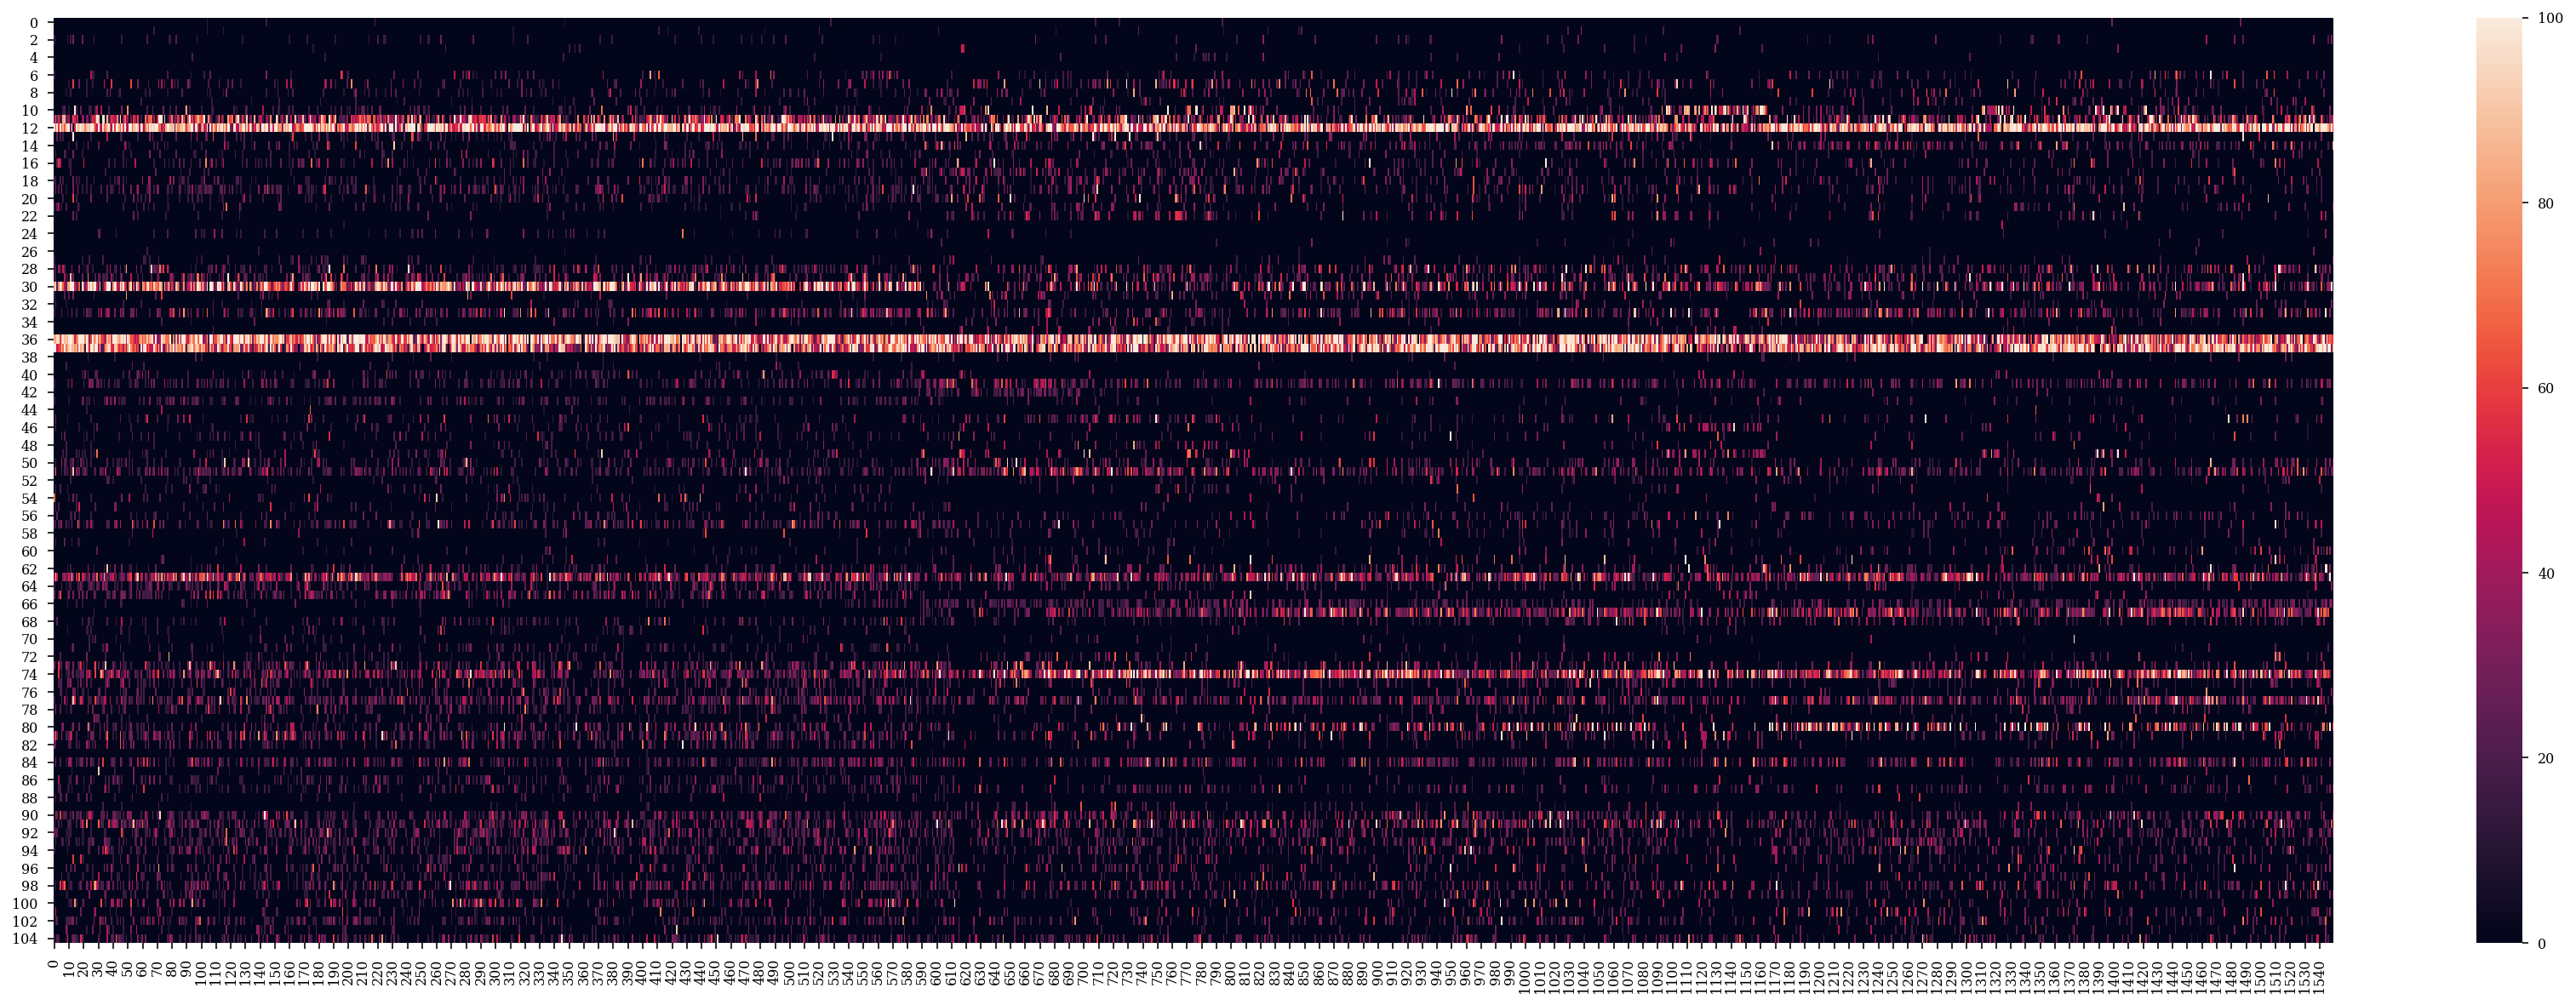

In [8]:
plt.figure(figsize=(30,10))
sns.heatmap(unit_mat,vmax=100)

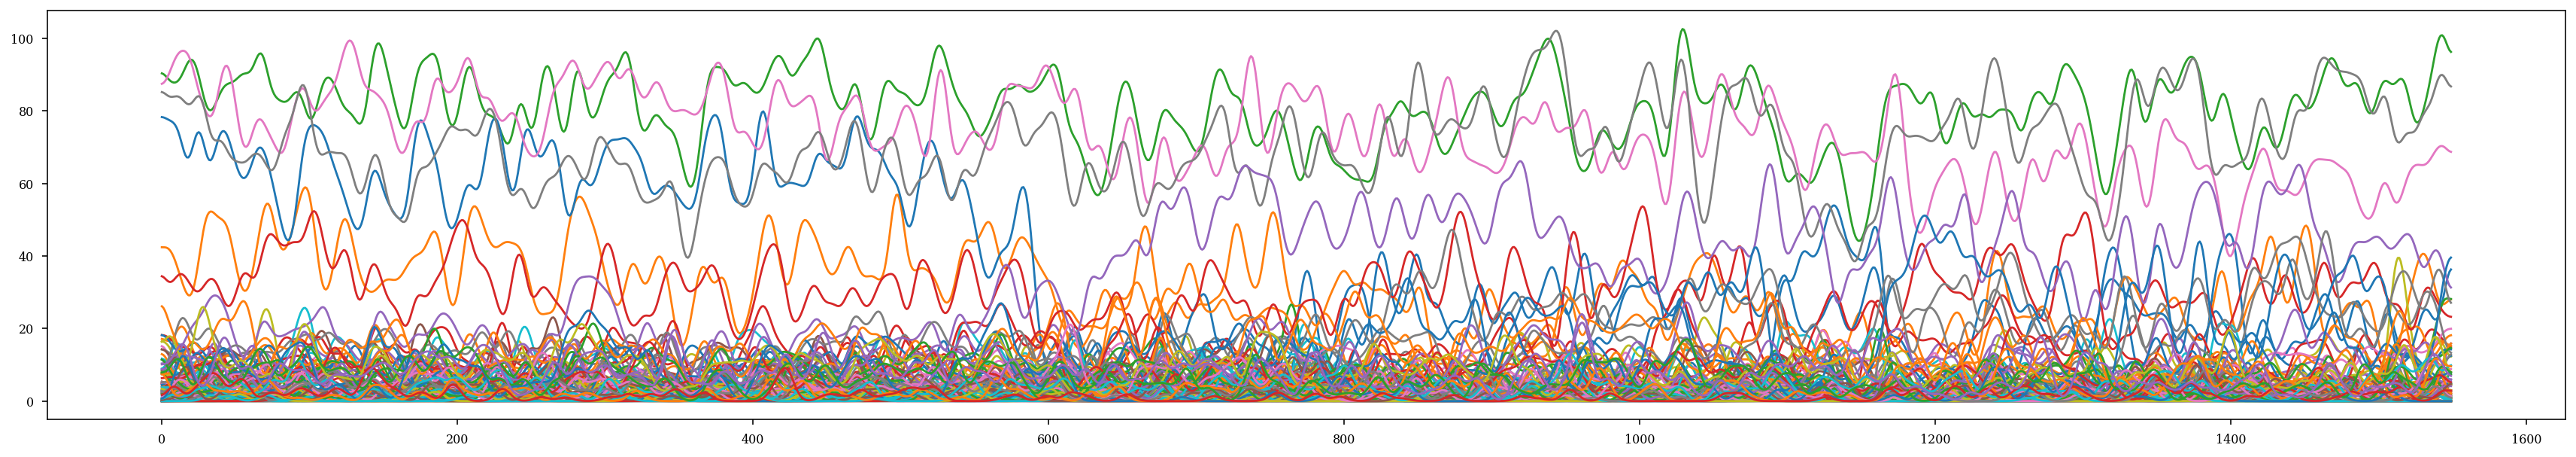

In [55]:
from scipy.ndimage import gaussian_filter1d

unit_mat_sm = gaussian_filter1d(unit_mat,5)

plt.figure(figsize=(30,5))
# sns.heatmap(unit_mat_sm,vmax=100)
plt.plot(unit_mat_sm.T)
plt.show()

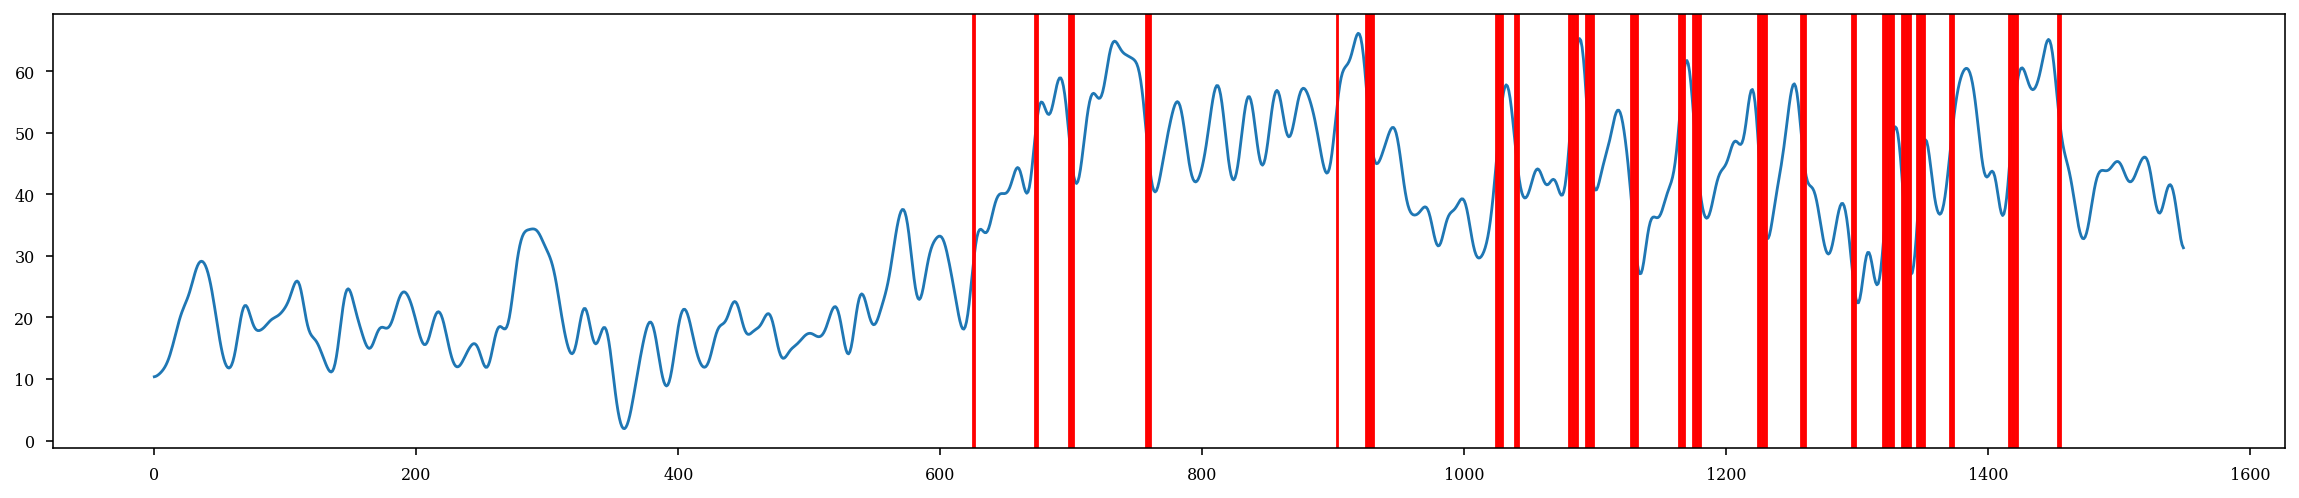

In [81]:
unit_mat_sm = gaussian_filter1d(unit_mat,5)

a = np.array(unit_mat_sm[74,:])
b = a[1:] - a[:-1]  
v = abs(b) > 2
edges = v.nonzero()[0] 
edges += 2  
edges

plt.figure(figsize=(20,4))
plt.plot(a)
for e in edges:
    plt.axvline(e,color='r')

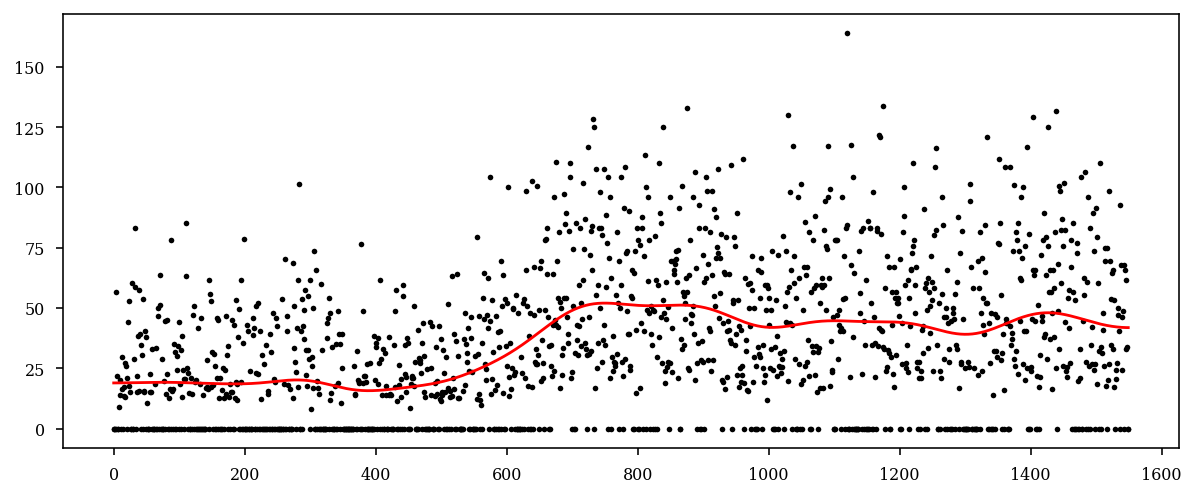

In [88]:
unit_mat_temp = unit_mat.copy()
# unit_mat_temp[unit_mat_temp == 0] = np.nan
unit_mat_sm = gaussian_filter1d(unit_mat_temp,50)

plt.figure(figsize=(10,4))
plt.plot(unit_mat[74,:],'.k')
plt.plot(unit_mat_sm[74,:],color="r")

In [91]:
np.std(unit_mat,axis=1)

array([ 1.67843829,  2.1183483 ,  4.62555385,  2.82791352,  2.52380892,
        0.        , 10.45117434, 13.33410681, 11.07640072,  6.44775289,
       22.03088334, 33.65823128, 35.1516061 , 12.65365339, 13.7432701 ,
        5.88192083, 13.58026207,  9.09158849, 10.5232992 , 12.47823593,
       11.75368348,  7.51245071, 10.59745153,  1.6657153 ,  4.66842349,
        2.33543817,  1.69729806,  5.15442095, 18.54118298, 17.18395661,
       39.16914444,  9.82880489,  5.35987787, 20.08264495,  5.96318201,
        5.0861083 , 36.23247382, 35.29518688,  3.52401466,  2.35924967,
        7.70713327, 14.50167082,  4.83990049,  8.31361302,  3.06026271,
       12.14763643,  7.80863076,  7.76358473,  6.93704979, 12.5892807 ,
       12.48242054, 18.34908505,  5.64090364,  6.26998794,  7.99143357,
        6.45768187,  8.7373249 , 13.90208699,  6.3267207 ,  4.05204389,
        7.51039805, 10.93859775, 13.65850518, 27.21472756, 10.61697603,
       12.33294906, 10.55333033, 21.92707784, 10.93191598,  4.42

<AxesSubplot:>

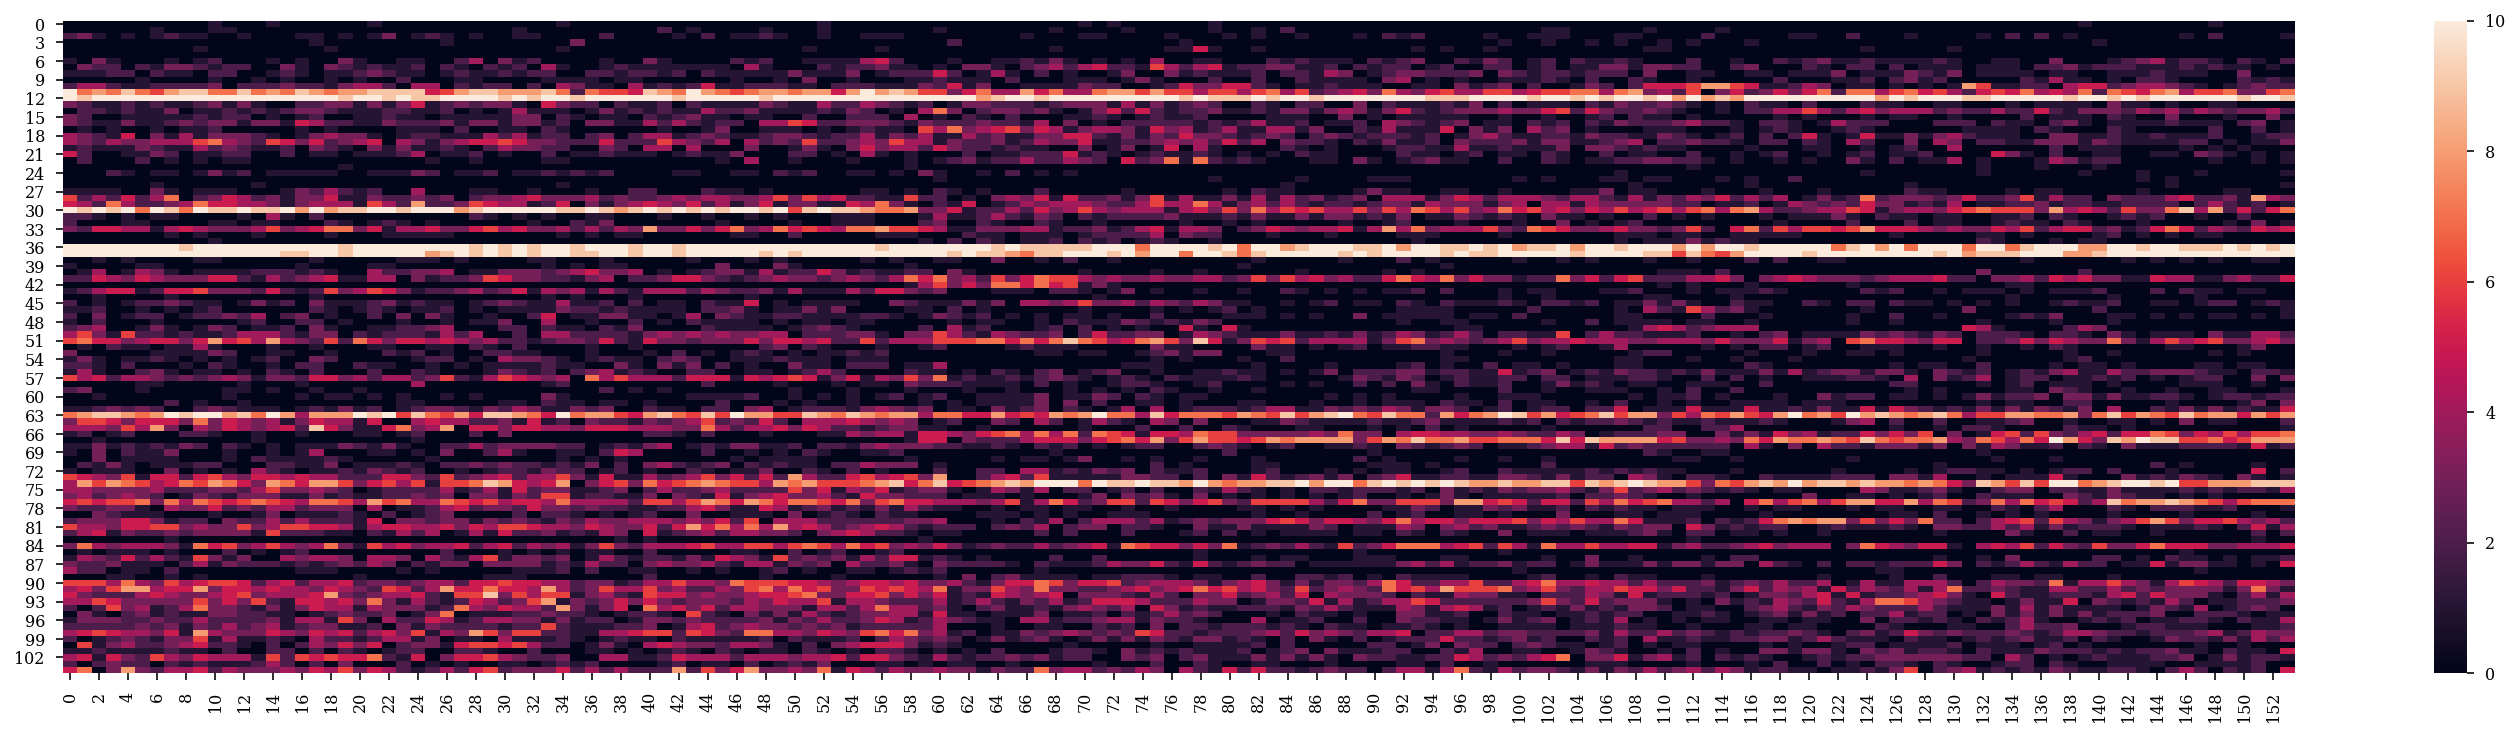

In [43]:
# plt.figure(figsize=(20,4))

# plt.plot(unit_mat[0,:])

unit_mat_binary = (unit_mat > 0)*1

# plt.figure(figsize=(20,4))
# plt.plot(unit_mat_binary[0,:])

bins = np.arange(0,unit_mat_binary.shape[1],10)
unit_mat_binary_sum = []
for i in range(len(bins)-1):
    unit_mat_binary_sum.append(unit_mat_binary[:,bins[i]:bins[i+1]].sum(axis=1))

unit_mat_binary_sum = np.vstack(unit_mat_binary_sum).T

plt.figure(figsize=(25,6))
sns.heatmap(unit_mat_binary_sum)

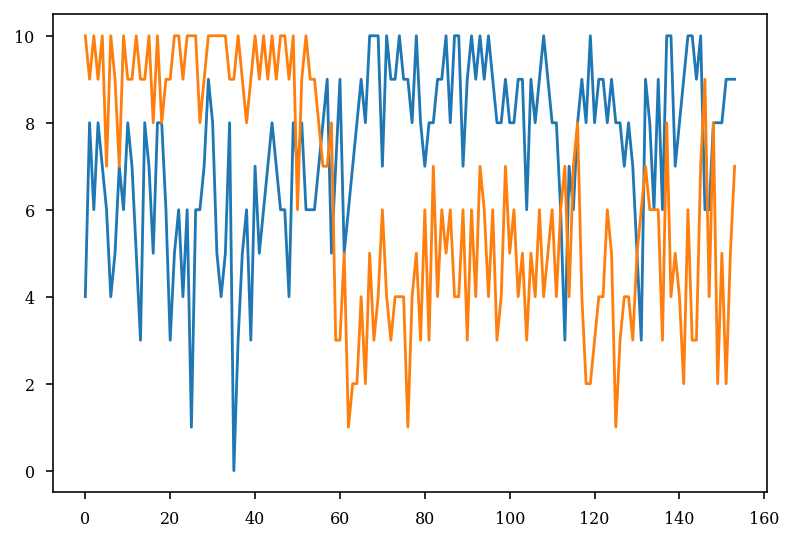

In [49]:
plt.plot(unit_mat_binary_sum[74,:])
plt.plot(unit_mat_binary_sum[30,:])

Narrow Interneuron
Narrow Interneuron


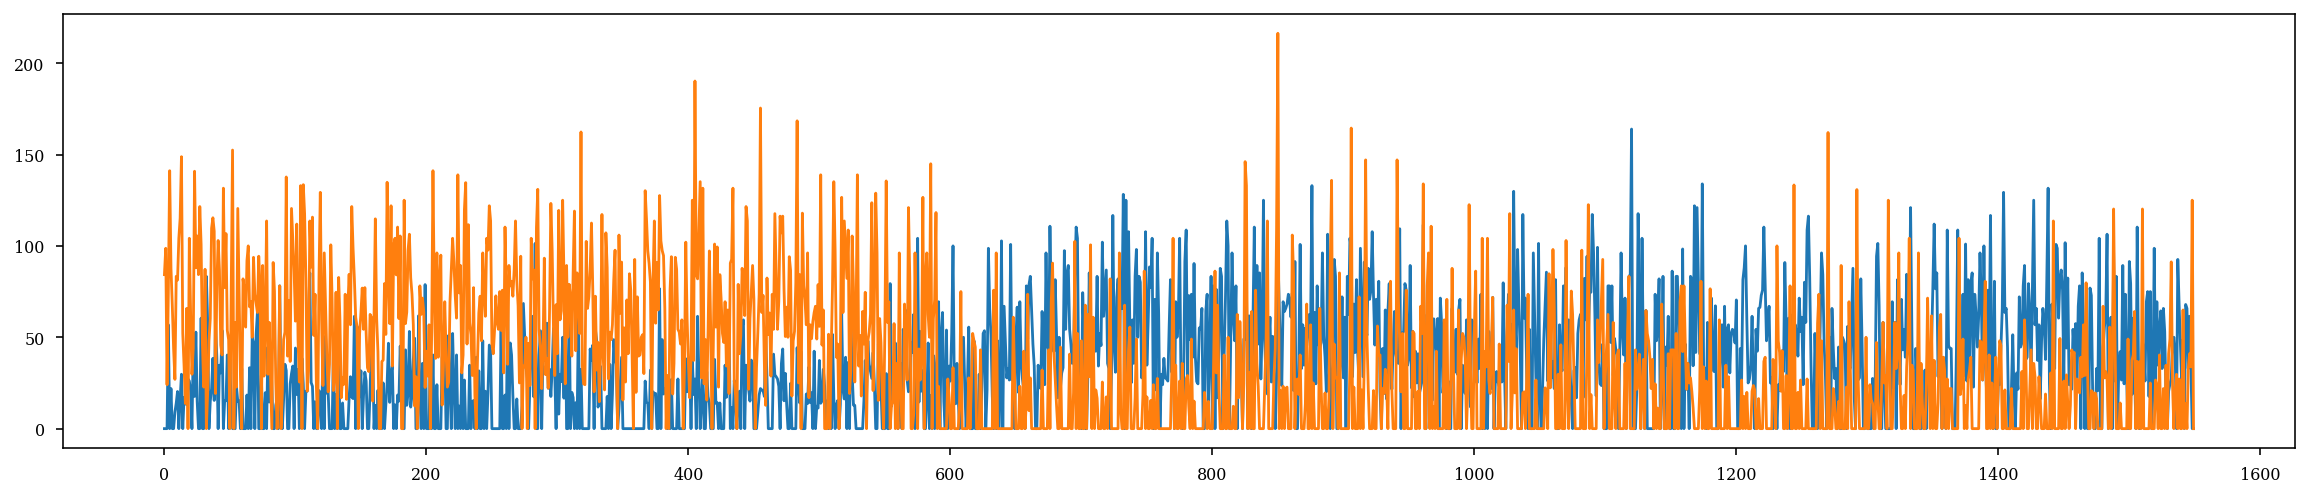

In [12]:
plt.figure(figsize=(20,4))

plt.plot(unit_mat[74,:])
plt.plot(unit_mat[30,:])

print(cell_metrics.putativeCellType.iloc[74])
print(cell_metrics.putativeCellType.iloc[30])
